In [1]:
from collections.abc import Callable
import random
from typing import Any, Dict
import datasets
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.transforms.functional as vF
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class VqaAnswerTransform(Callable):
    def __call__(self, batch):
        answers = batch['answers']
        del batch['answers']
        i = random.randint(0, len(answers[0])-1)
        batch['answer'] = [a[i]['answer'] for a in answers]
        return batch

In [3]:
ok_vqa_builder = datasets.load_dataset_builder('HuggingFaceM4/OK-VQA', trust_remote_code=False)
ok_vqa_builder.download_and_prepare(file_format='arrow')
ds = ok_vqa_builder.as_dataset()
vqa_transforms = transforms.Compose([
    transforms.Resize(size=(256, 256)),  # Would you believe order matters here?
                                         # https://github.com/pytorch/vision/blob/main/torchvision/transforms/v2/_transform.py#L57
    transforms.PILToTensor(),
    VqaAnswerTransform(),
])
ds.set_transform(vqa_transforms)
train = ds['train'].shuffle(seed=42)
valid = ds['validation'].shuffle(seed=42)

Using the latest cached version of the module from /home/eihli/.cache/huggingface/modules/datasets_modules/datasets/HuggingFaceM4--OK-VQA/33fb0e5856ea617c9d69b3feb4c67fba7ff98fd7b38e19bebc285b87e68326fb (last modified on Thu Mar 28 15:57:27 2024) since it couldn't be found locally at HuggingFaceM4/OK-VQA, or remotely on the Hugging Face Hub.
/home/eihli/.virtualenvs/neko/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


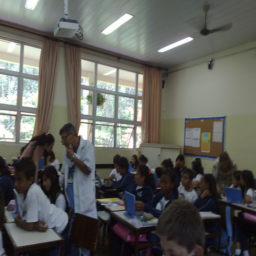

(torch.Size([3, 256, 256]),
 None,
 {'image': tensor([[[176, 174, 174,  ...,  85,  84,  84],
           [178, 176, 175,  ...,  84,  84,  85],
           [178, 173, 173,  ...,  83,  83,  85],
           ...,
           [132, 119,  93,  ...,  26,  23,  22],
           [122,  93,  59,  ...,  27,  25,  22],
           [100,  68,  69,  ...,  29,  28,  27]],
  
          [[191, 188, 187,  ...,  85,  86,  84],
           [192, 189, 188,  ...,  85,  85,  84],
           [189, 185, 186,  ...,  85,  85,  84],
           ...,
           [135, 127,  94,  ...,  23,  21,  21],
           [129,  99,  64,  ...,  22,  21,  20],
           [102,  67,  72,  ...,  20,  21,  22]],
  
          [[184, 180, 178,  ...,  77,  78,  79],
           [185, 181, 179,  ...,  80,  80,  79],
           [183, 177, 177,  ...,  76,  75,  74],
           ...,
           [153, 142, 112,  ...,  19,  16,  16],
           [145, 117,  82,  ...,  19,  17,  13],
           [121,  88,  91,  ...,  18,  17,  13]]], dtype=torch.uint

In [4]:
example = train[0]
image = example['image']
image.shape, display(vF.to_pil_image(image)), example

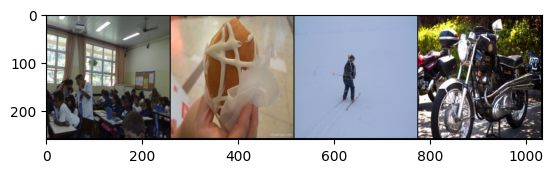

In [5]:
data_loader = DataLoader(train, batch_size=4, shuffle=False)
batch = next(iter(data_loader))
grid = torchvision.utils.make_grid(batch['image'], nrow=4)
plt.imshow(torch.permute(grid, (1, 2, 0)))

In [6]:
from accelerate import Accelerator, DistributedDataParallelKwargs
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm
from gato.policy.gato_policy import GatoPolicy
from gato.training.arguments import TrainingArgs
from gato.training.schedulers import get_linear_warmup_cosine_decay_scheduler
from gato.tasks.vqa_task import VqaTask
from gato.training.trainer import Trainer
from pathlib import Path
import wandb
from transformers import AutoTokenizer
%load_ext autoreload
%autoreload 2

from gato.tasks.vqa_task import VqaTask

In [7]:
accelerator = Accelerator(cpu=True)
args = TrainingArgs(
    training_steps=1,
    log_eval_freq=1,
    warmup_steps=0,
    batch_size=1,
    eval_episodes=1,
    vqa_prop=1,
)

In [8]:
train = DataLoader(ds['train'], batch_size=4, shuffle=False)
valid = DataLoader(ds['validation'], batch_size=4, shuffle=False)

In [9]:
vqa_task = VqaTask(train, valid)

dict_keys(['image', 'question_type', 'confidence', 'image_id', 'answer_type', 'question_id', 'question', 'answer'])
torch.Size([4, 3, 256, 256])


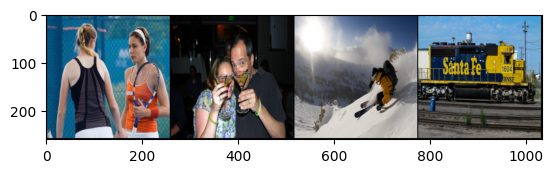

In [10]:
batch = vqa_task.sample_batch()
print(batch.keys())
print(batch['image'].shape)
grid = torchvision.utils.make_grid(batch['image'], nrow=4)
plt.imshow(torch.permute(grid, (1, 2, 0)))

In [11]:
batch

{'image': tensor([[[[  4,   5,   2,  ...,  55,  52,  62],
           [  6,   6,   5,  ...,  64,  65,  71],
           [  5,   4,   8,  ...,  65,  70,  76],
           ...,
           [ 65, 134, 140,  ...,  41,  42,  40],
           [ 21, 100, 124,  ...,  44,  45,  44],
           [  7,  62, 109,  ...,  35,  41,  43]],
 
          [[ 75,  75,  76,  ..., 116, 113, 118],
           [ 79,  77,  76,  ..., 119, 119, 121],
           [ 80,  78,  79,  ..., 122, 123, 127],
           ...,
           [118, 158, 162,  ..., 103, 102, 103],
           [ 94, 135, 150,  ..., 105, 105, 105],
           [ 86, 111, 140,  ..., 105, 104, 104]],
 
          [[113, 115, 114,  ..., 127, 126, 129],
           [116, 116, 115,  ..., 129, 129, 129],
           [117, 116, 119,  ..., 128, 127, 130],
           ...,
           [142, 175, 178,  ..., 112, 111, 112],
           [126, 153, 169,  ..., 114, 112, 114],
           [121, 138, 162,  ..., 112, 112, 114]]],
 
 
         [[[  4,   5,   4,  ...,   8,   8,   8],


In [12]:
model = GatoPolicy(
    device=args.device,
    embed_dim=args.embed_dim,
    layers=args.layers,
    heads=args.heads,
    dropout=args.dropout,
    mu=args.mu,
    M=args.M,
    patch_size=args.patch_size,
    resid_mid_channels=args.resid_mid_channels,
    continuous_tokens=args.continuous_tokens,
    discrete_tokens=args.discrete_tokens,
    context_len=args.sequence_length,
    use_patch_pos_encoding=not args.disable_patch_pos_encoding,
    use_pos_encoding=not args.disable_inner_pos_encoding,
    activation_fn=args.activation_fn,
    pretrained_lm=args.pretrained_lm,
    flash=args.flash,
    tokenizer_model_name=args.tokenizer_model_name,
    pad_seq=args.pad_seq,
)
model.text_tokenizer.pad_token = model.text_tokenizer.eos_token

In [13]:
batch = vqa_task.sample_batch()
model.text_tokenizer(batch['question'])

{'input_ids': [[3792, 262, 2933, 14899, 393, 1804, 1194, 1660, 3842, 30], [5195, 466, 3988, 24170, 30], [2215, 373, 428, 3704, 286, 17702, 5112, 15646, 30], [5195, 318, 428, 3818, 1262, 428, 4235, 286, 9358, 30]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [14]:
vqa_task.evaluate(model, log_examples_to_output=True)

--- examples ---


/home/eihli/.virtualenvs/neko/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2637: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Target answer: condiment 
 Predicted answer : odus Fan
----
Target answer: wet suit 
 Predicted answer : plus breathswhel
----
Target answer: diner 
 Predicted answer :  clickedIAL
----
--- examples end ---


{'loss': 10.916721725463868, 'perplexity': 55089.8828125}